## Intro to Graph Databases and Network Science

Network science is an academic field which studies complex networks such as telecommunication networks, computer networks, biological networks, cognitive and semantic networks, and social networks, considering distinct elements or actors represented by nodes (or vertices) and the connections between the elements or actors as links (or edges). The field draws on theories and methods including graph theory from mathematics, statistical mechanics from physics, data mining and information visualization from computer science, inferential modeling from statistics, and social structure from sociology. (from wikipedia)

In [1]:
import os
import operator
import codecs
import random
import math
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import networkx as nx

from collections import Counter, OrderedDict

import urllib
from bs4 import BeautifulSoup
#import pydot

#import datashader as ds
#import datashader.transfer_functions as tf
#from datashader.layout import random_layout, circular_layout, forceatlas2_layout
#from datashader.bundling import connect_edges, hammer_bundle

#import holoviews.operation.datashader as hd
#import holoviews as hv
#hv.extension("bokeh")

from SPARQLWrapper import SPARQLWrapper, JSON    #sudo pip3 install --upgrade SPARQLWrapper

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

###  Philosophers Influences Chain  

Based on [this](https://www.analyticsvidhya.com/blog/2018/09/introduction-graph-theory-applications-python/), with examples inspired in [this](http://www.coppelia.io/2012/06/graphing-the-history-of-philosophy/) and [this](http://brendangriffen.com/blog/gow-influential-thinkers) experiments. Information crawled from [DBpedia](https://wiki.dbpedia.org/).

The internet is big — very big. One such way to investigate all of this free online content is through graphs.  
To start, let’s look at how people influenced each other throughout history as entered by the authors of Wikipedia.  
If you search for a notable figure you might find the following on the sidebar:  


## [Aristotle Facts](https://en.wikipedia.org/wiki/Aristotle)

Here we see a list of people that have been influenced by Aristotle. We also see who Aristotle himself was influenced by. At the moment, these are just names, but this provides a way we can connect Aristotle to other people throughout history. If only we had a way to collect this data using a simple database-like query.

Our task is to answer the questions:  

 1) What are the top 10 personalities in terms of power to generate influences?  
 2) What are the 10 personalities that were influenced by the most number of people?  
 3) What are the 5 major "clusters" of personalities who were influenced by a similar group of the same influencers?   
(Consider a cluster as the group of personalities who were influenced by the same Y influencers, Y being an arbitrary number. Start with Y = 2 and grow until there is no 2 people influenced by all of them.  

 4) What are the 5 major influences chains (eg, A -> B -> C -> ...)?  
 5) What are the countries that generated the greatest influential?  
 6) What are the areas of greatest influence?  
 7) Create a graphical representation of the graph  

Collect Data

First we require a database-like, indexed version of Wikipedia to collect our data. [DBpedia](https://wiki.dbpedia.org/) is one such venture which has been created as part of the Wikipedia project. This structured content is then made available to the public at no cost. DBpedia allows you to query relationships and properties associated with Wikipedia resources, including links to other related datasets. The first graph will connect people via their known influences. The snippet of code entered into the [SPARQL Explorer](http://dbpedia.org/snorql/) looks something like this:

In [2]:
sparql_query = '''
SELECT * WHERE
{?p a <http://dbpedia.org/ontology/Person>.
?p <http://dbpedia.org/ontology/influenced> ?influenced.
?influenced a <http://dbpedia.org/ontology/Person>. }
'''

If you'd want to do the same process with, say, programming languages, the query would be:

In [3]:
sparql_query2 = '''
SELECT *
WHERE { ?p a <http://dbpedia.org/ontology/ProgrammingLanguage> .
?p <http://dbpedia.org/ontology/influenced> ?influenced . }
'''

But we can use Python to make a direct query and use the results:

In [4]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [5]:
len(results['results']['bindings'])

8589

In [6]:
results['results']['bindings'][0]

{'p': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Lenny_Bruce'},
 'influenced': {'type': 'uri',
  'value': 'http://dbpedia.org/resource/Abbie_Hoffman'}}

In [7]:
for result in results['results']['bindings'][90:100]:
    print(result['influenced']['value'].strip('http://dbpedia.org/resource/').replace('_',' '), 
          ' --> ', result['p']['value'].strip('http://dbpedia.org/resource/').replace('_',' '))

Jim B  -->  Lloyd Alexan
Catherynne M. Valen  -->  Roger Zelazny
Christian Cardell C  -->  Florence Wyl
Elizabeth Bradford Holbrook  -->  Florence Wyl
Octavio Paz  -->  Stéphane Mallarmé
Octavio Paz  -->  Rubén Darí
Albert G  -->  Otto Hahn
Carol Ann Duffy  -->  Ted H
David Bohm  -->  Alfred North W
Dian Fossey  -->  George Schall


In [8]:
with open("../SampleDBs/influences.csv", mode= 'w', encoding="utf-8") as f:
    f.write('"influences";"influenced"\n')
    for result in results['results']['bindings']:
        f.write('"{}";"{}"\n'.format(result['influenced']['value'].strip('http://dbpedia.org/resource/').replace('_',' '),
                                     result['p']['value'].strip('http://dbpedia.org/resource/').replace('_',' ')))

But we will work with a cleaner version of the file, because some of the URLs present incomplete names and we would need to query each individual page to grab them.

Specifying the path to the files:

In [9]:
datapath = "../SampleDBs/"
outputs = "../SampleDBs/"
dataset1 = "influences.csv"

#### Loading the dataset

In [10]:
csvfile = codecs.open(os.path.join(datapath,dataset1), encoding="utf-8").readlines()

In [11]:
len(csvfile)

8590

In [12]:
csvfile[0:5]

['"influences";"influenced"\n',
 '"Abbie Hoffman";"Lenny B"\n',
 '"Alfred Marshall";"Léon Wal"\n',
 '"Amartya Sen";"John Maynard Keyn"\n',
 '"Amartya Sen";"Kenneth Arrow"\n']

#### Doing some cleaning  

In [13]:
lines = [line.strip() for line in csvfile]
lines2 = []
for line in lines:
    line = line.replace('",','";')
    line = line.replace('"','').strip()
    lines2.append(line)
for line in lines2[0:6]:
    print(line)

influences;influenced
Abbie Hoffman;Lenny B
Alfred Marshall;Léon Wal
Amartya Sen;John Maynard Keyn
Amartya Sen;Kenneth Arrow
Ambrosius Holbein;Hans Holbein the El


In [14]:
influences = np.array([(line.split(';')[0],line.split(';')[1]) for line in lines2])
print('Dimensions: {}'.format(influences.shape))
influences[:10]

Dimensions: (8590, 2)


array([['influences', 'influenced'],
       ['Abbie Hoffman', 'Lenny B'],
       ['Alfred Marshall', 'Léon Wal'],
       ['Amartya Sen', 'John Maynard Keyn'],
       ['Amartya Sen', 'Kenneth Arrow'],
       ['Ambrosius Holbein', 'Hans Holbein the El'],
       ['Andrzej Waj', 'Jerzy Grotowsk'],
       ['Anthony B', 'Ford Madox F'],
       ['Anthony B', 'Vladimir Nabokov'],
       ['Bill Hick', 'Lenny B']], dtype='<U69')

In [15]:
pd_influences = pd.DataFrame(influences[1:,:], columns = influences[0])
pd_influences.head(10)

,influences,influenced
0,Abbie Hoffman,Lenny B
1,Alfred Marshall,Léon Wal
2,Amartya Sen,John Maynard Keyn
3,Amartya Sen,Kenneth Arrow
4,Ambrosius Holbein,Hans Holbein the El
5,Andrzej Waj,Jerzy Grotowsk
6,Anthony B,Ford Madox F
7,Anthony B,Vladimir Nabokov
8,Bill Hick,Lenny B
9,Bob Black,Abbie Hoffman


In [16]:
#nodes = influences[1:,0]
#edges = influences[1:,1]
G = nx.DiGraph()
G.add_edges_from(influences[1:], weight = 1)

print('Number of nodes is: {}'.format(G.number_of_nodes()))
print('Number of edges is: {}'.format(G.number_of_edges()))
print()
#print(G.edges())

Number of nodes is: 7233
Number of edges is: 8587



In [17]:
list(G.neighbors('Vladimir Nabokov'))

['Ivan Turgenev',
 'Gustave Fl',
 'Robert Louis Stevenson',
 'Thomas Mayne R',
 'Nikolai Gogol']

In [18]:
list(G.successors('Vladimir Nabokov'))

['Ivan Turgenev',
 'Gustave Fl',
 'Robert Louis Stevenson',
 'Thomas Mayne R',
 'Nikolai Gogol']

In [19]:
list(G.predecessors('Vladimir Nabokov'))

['Anthony B',
 'Thomas Pynchon',
 'Edmund Y',
 'John Banvill',
 'David Cronen',
 'John Updik',
 'Stanley Kubrick',
 'Zadie Sm',
 'Daniel Handl',
 'Don DeLill',
 'Jeffrey Eugen',
 'Martin Am',
 'Nick Cav',
 'Christopher Hitchen',
 'Daniel Clow',
 'Jhumpa L',
 'Michael Chabon',
 'Terence McKenn',
 'Victor Pelevin',
 'Gene Wolf',
 'Joanna Newsom',
 'Oğuz Atay',
 'Javier Marí',
 'Richard Rorty']

In [20]:
list(G.adjacency())[0:2]

[('Abbie Hoffman',
  {'Lenny B': {'weight': 1},
   'Marshall McLuhan': {'weight': 1},
   'Herbert M': {'weight': 1},
   'Abraham Maslow': {'weight': 1}}),
 ('Lenny B', {'Mort Sahl': {'weight': 1}, 'Irwin Corey': {'weight': 1}})]

1) What are the top 10 personalities in terms of power to generate influences?  

In [21]:
#most_influencers = Counter(influences[1:,0]).most_common(10)
most_influencers = Counter(dict(G.out_degree())).most_common(10)
df_influencers = pd.DataFrame(most_influencers, columns = ['Influencer', '#influenced'] )
df_influencers

,Influencer,#influenced
0,Friedrich Nietz,27
1,Martin H,22
2,Karl Marx,21
3,Michel Foucaul,20
4,Gilles Deleuz,18
5,William Jam,17
6,Bertrand Russell,16
7,Edmund Husserl,16
8,Murray R,16
9,Immanuel Kan,16


Text(0.5, 1.0, 'Most influents')

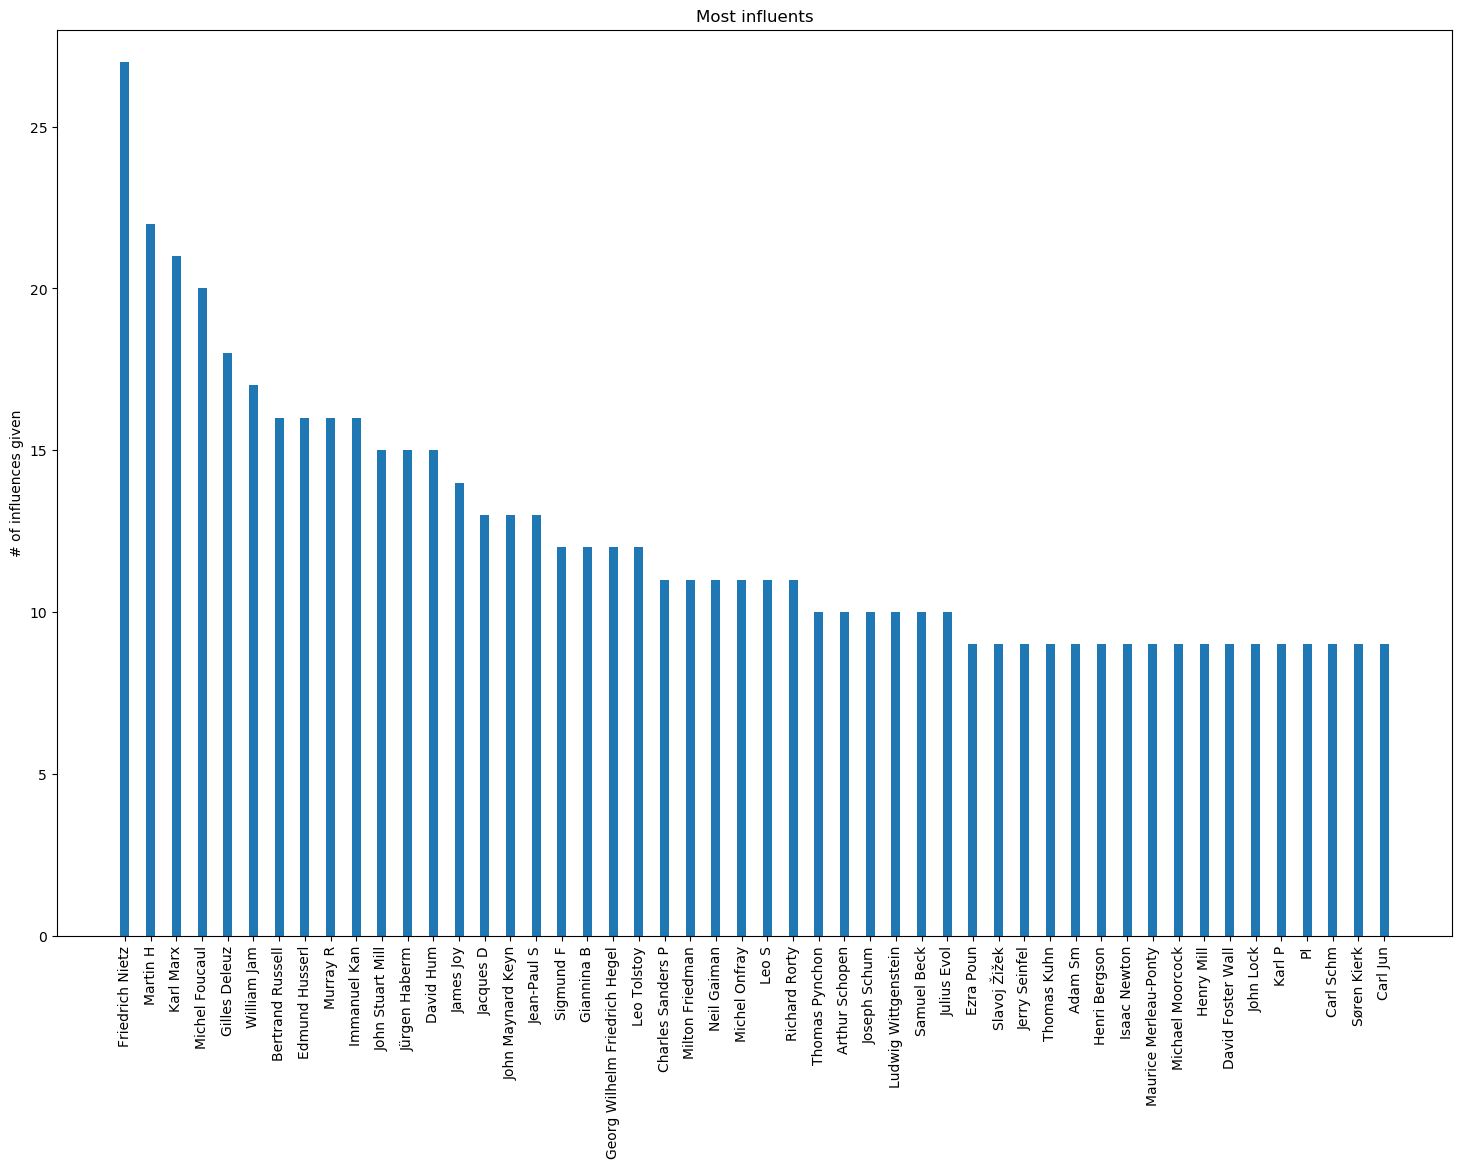

In [22]:
x = np.arange(len(Counter(influences[1:,0]).most_common(50)))
y = list(zip(*Counter(influences[1:,0]).most_common(50)))[1]
labels = list(zip(*Counter(influences[1:,0]).most_common(50)))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=90)
plt.ylabel('# of influences given')
plt.title('Most influents')

Calculating the Pagerank

In [23]:
pr = nx.pagerank(G.reverse())
pr_sorted = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
pr_sorted[0:20]

[('Edward S', 0.000870386036475088),
 ('Michel Foucaul', 0.0007850605575474715),
 ('Ludwig Wittgenstein', 0.0007646463309158927),
 ('Theodor W. Adorn', 0.0007557018509422481),
 ('David Foster Wall', 0.0006816730953387156),
 ('John Stuart Mill', 0.0006661399123114359),
 ('Imre Lak', 0.0006432551894371495),
 ('Gilles Deleuz', 0.0006016859404865415),
 ('John Maynard Keyn', 0.0005979157499774748),
 ('Abdus Salam', 0.0005975085972426806),
 ('Roman', 0.0005975085972426806),
 ('Jürgen Haberm', 0.0005933422791264188),
 ('William Jam', 0.0005769150887961481),
 ('Friedrich Nietz', 0.0005737768777933557),
 ('Giannina B', 0.0005636229293326173),
 ('Roger J-B W', 0.0005594846348090833),
 ('Gayatri Chakravorty Spivak', 0.0005478681285082753),
 ('Richard Dawkin', 0.0005455710142368763),
 ('Michel Onfray', 0.0005404698716535891),
 ('Isaac Newton', 0.0005381322933356726)]

In [24]:
bb = nx.betweenness_centrality(G)
bb_sorted = sorted(bb.items(), key=operator.itemgetter(1), reverse=True)
bb_sorted[0:20]

[('Immanuel Kan', 0.0008863168989708462),
 ('E', 0.0006587032619824896),
 ('William Jam', 0.000633258043525638),
 ('David Hum', 0.000534951544522477),
 ('John Stuart Mill', 0.0005148991548240061),
 ('Edmund Husserl', 0.000456241507124821),
 ('Georg Wilhelm Friedrich Hegel', 0.00037416340685577433),
 ('Max W', 0.0003720017707197295),
 ('Ludwig Wittgenstein', 0.00035900209757856575),
 ('Friedrich Nietz', 0.0003547015477411171),
 ('A', 0.00033516225081502084),
 ('Jean-Jacques R', 0.00032901980424178347),
 ('Gottfried Wilhelm Leibniz', 0.0003224002288943368),
 ('Martin H', 0.0003191940991895533),
 ('Hilary Putnam', 0.0003188480216596636),
 ('Johann Gottlieb F', 0.0003164301543834713),
 ('Baruch Spinoz', 0.0003156522590224273),
 ('Wilhelm Dilthey', 0.0002815543219862174),
 ('George Bool', 0.00027369526361076),
 ('S', 0.00025890279885473083)]

In [25]:
nx.set_node_attributes(G, bb, 'betweenness')
nx.set_node_attributes(G, pr, 'pagerank')

print(G.nodes['Friedrich Nietz']['betweenness'])

print(G.nodes['Karl Marx']['pagerank'])

0.0003547015477411171
0.0005150528177899495


In [26]:
G.nodes["Karl Marx"]

{'betweenness': 0.0, 'pagerank': 0.0005150528177899495}

 2) What are the 10 personalities that were influenced by the most number of people? 

In [27]:
#most_influenced = Counter(influences[1:,1]).most_common(10)
most_influenced = Counter(dict(G.in_degree())).most_common(10)
df_influenced = pd.DataFrame(most_influenced, columns = ['Influenced', '#influences'] )
df_influenced

,Influenced,#influences
0,Georg Wilhelm Friedrich Hegel,48
1,Urmuz,38
2,Immanuel Kan,34
3,William S. B,32
4,Lenny B,31
5,Cornelius C,31
6,Martin H,30
7,Edmund Husserl,30
8,Robert E. How,29
9,Friedrich Nietz,28


Text(0.5, 1.0, 'Most influents')

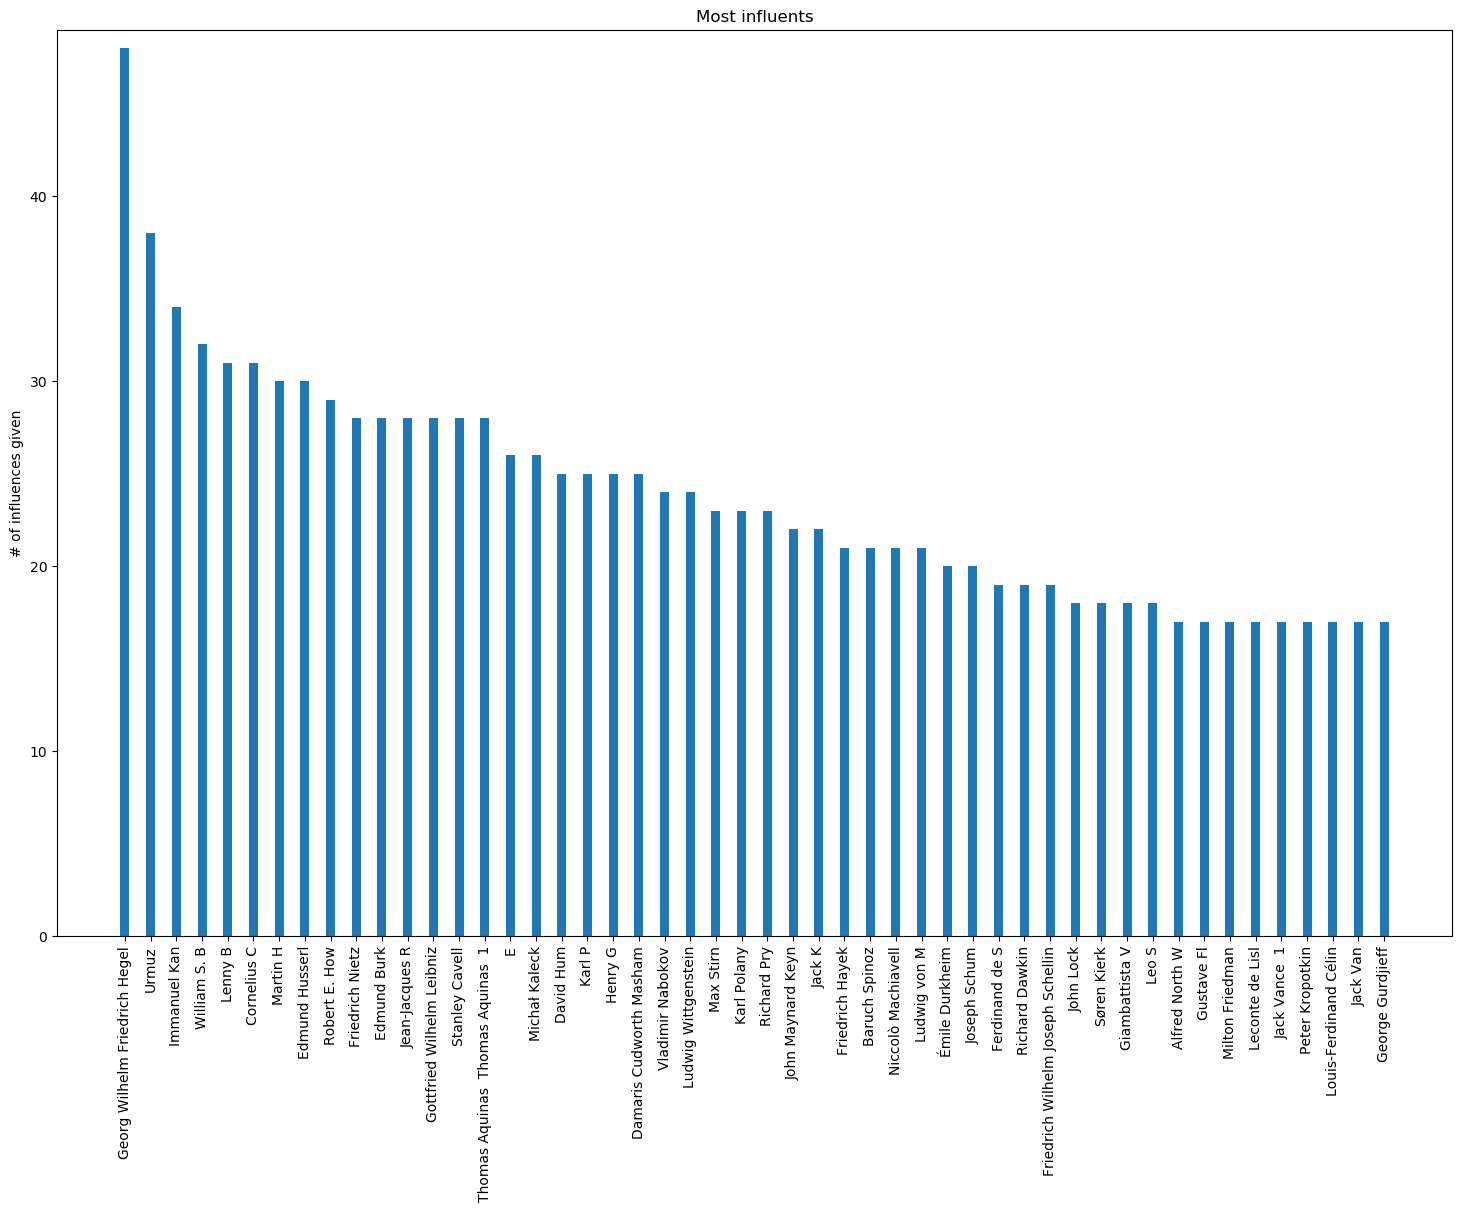

In [28]:
x = np.arange(len(Counter(influences[1:,1]).most_common(50)))
y = list(zip(*Counter(influences[1:,1]).most_common(50)))[1]
labels = list(zip(*Counter(influences[1:,1]).most_common(50)))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=90)
plt.ylabel('# of influences given')
plt.title('Most influents')

3) What are the 5 major "clusters" of personalities who were influenced by a similar group of the same influencers?   

(Consider a cluster as the group of personalities who were influenced by the same $\tau$ influencers, $\tau$ being an arbitrary number. Start with $\tau$ = 2 and grow until there is no 2 people influenced by all of them.  

4) What are the 5 major influences chains (eg, A -> B -> C -> ...)?

In [29]:
#Shortest path between all nodes
crescent_shortest_paths = nx.all_pairs_shortest_path(G)

paths = []
for key, dictvalue in crescent_shortest_paths:
    for key, value in dictvalue.items():
        paths.append(value)

In [30]:
path_sizes = [len(p) for p in paths]

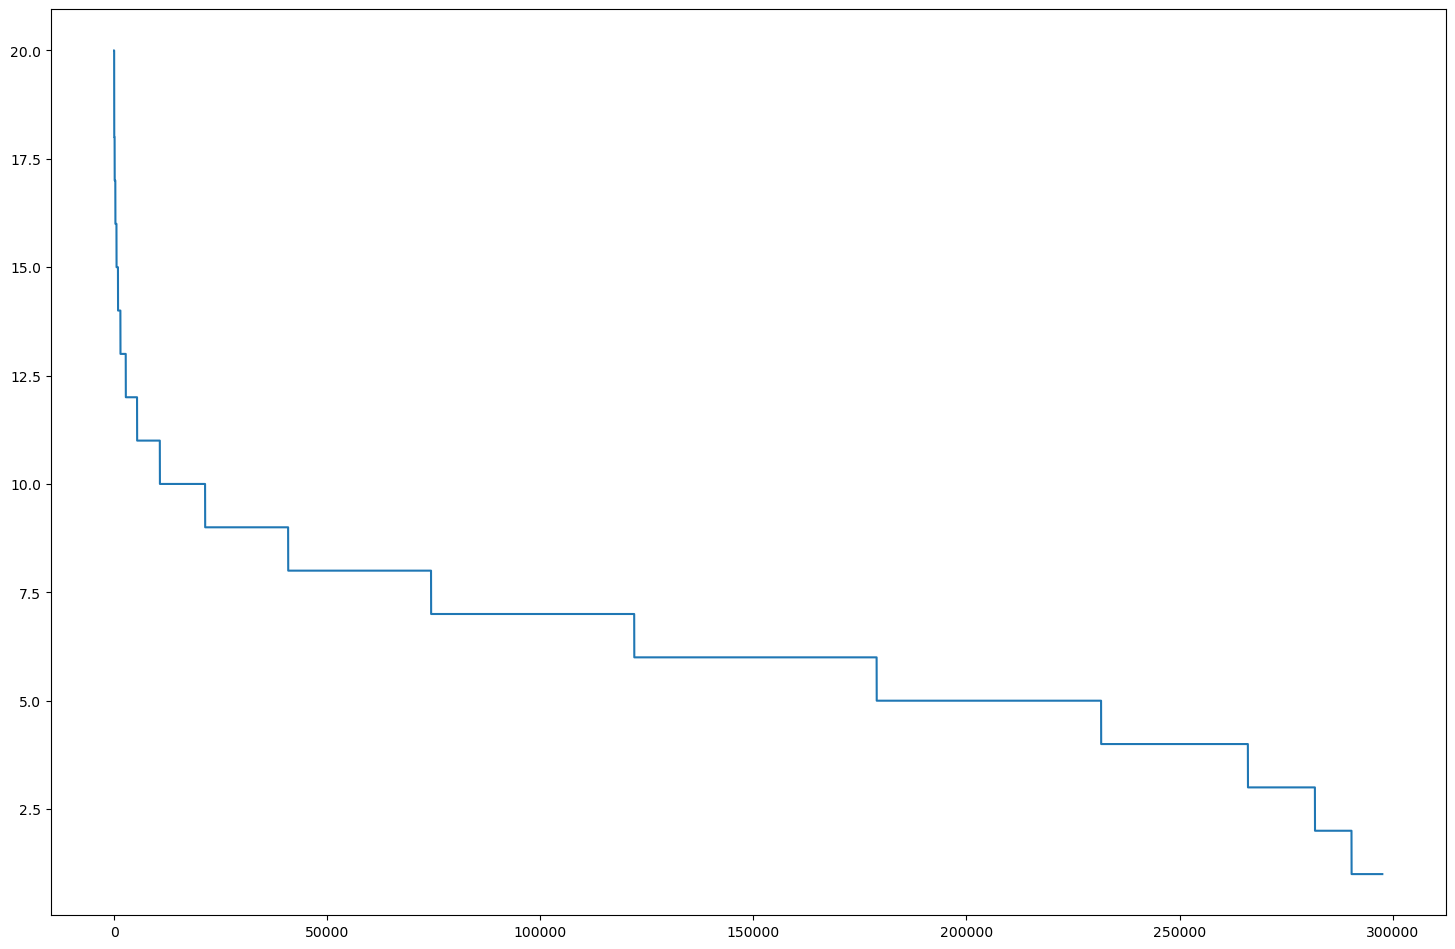

In [31]:
plt.figure(figsize=(18,12), dpi=100)
plt.plot(sorted(path_sizes, reverse=True))

In [32]:
crescent_shortest_paths = nx.all_pairs_shortest_path(G)
longest_paths = []
for key, dictvalue in crescent_shortest_paths:
    for key, value in dictvalue.items():
        if(len(value) > 14):
            longest_paths.append(value)

Path 1: ['Herbert Blum', 'W. I. Thom', 'Gabriel T', 'Gottfried Wilhelm Leibniz', 'Blaise Pascal', 'Michel de Montaign', 'Sextus Em', 'Py', 'Dem', 'L', 'E', 'Zeno of Citium', 'Crates of T', 'Antisthen', 'G']

Path 2: ['Herbert Blum', 'W. I. Thom', 'Gabriel T', 'Gottfried Wilhelm Leibniz', 'Blaise Pascal', 'Michel de Montaign', 'Sextus Em', 'Py', 'Dem', 'L', 'E', 'A', 'S', 'Virgil', 'Philodem']

Path 3: ['Herbert Blum', 'W. I. Thom', 'Gabriel T', 'Gottfried Wilhelm Leibniz', 'Blaise Pascal', 'Michel de Montaign', 'Sextus Em', 'Py', 'Dem', 'L', 'E', 'A', 'S', 'Parmen', 'Heracl']

Path 4: ['Herbert Blum', 'W. I. Thom', 'Gabriel T', 'Gottfried Wilhelm Leibniz', 'Blaise Pascal', 'Michel de Montaign', 'Sextus Em', 'Py', 'Dem', 'L', 'E', 'A', 'S', 'Posidon', 'Pan']

Path 5: ['Herbert Blum', 'W. I. Thom', 'Gabriel T', 'Gottfried Wilhelm Leibniz', 'Blaise Pascal', 'Michel de Montaign', 'Sextus Em', 'Py', 'Dem', 'L', 'E', 'Zeno of Citium', 'Crates of T', 'Antisthen', 'G', 'Zeno of El']

Path 6: [

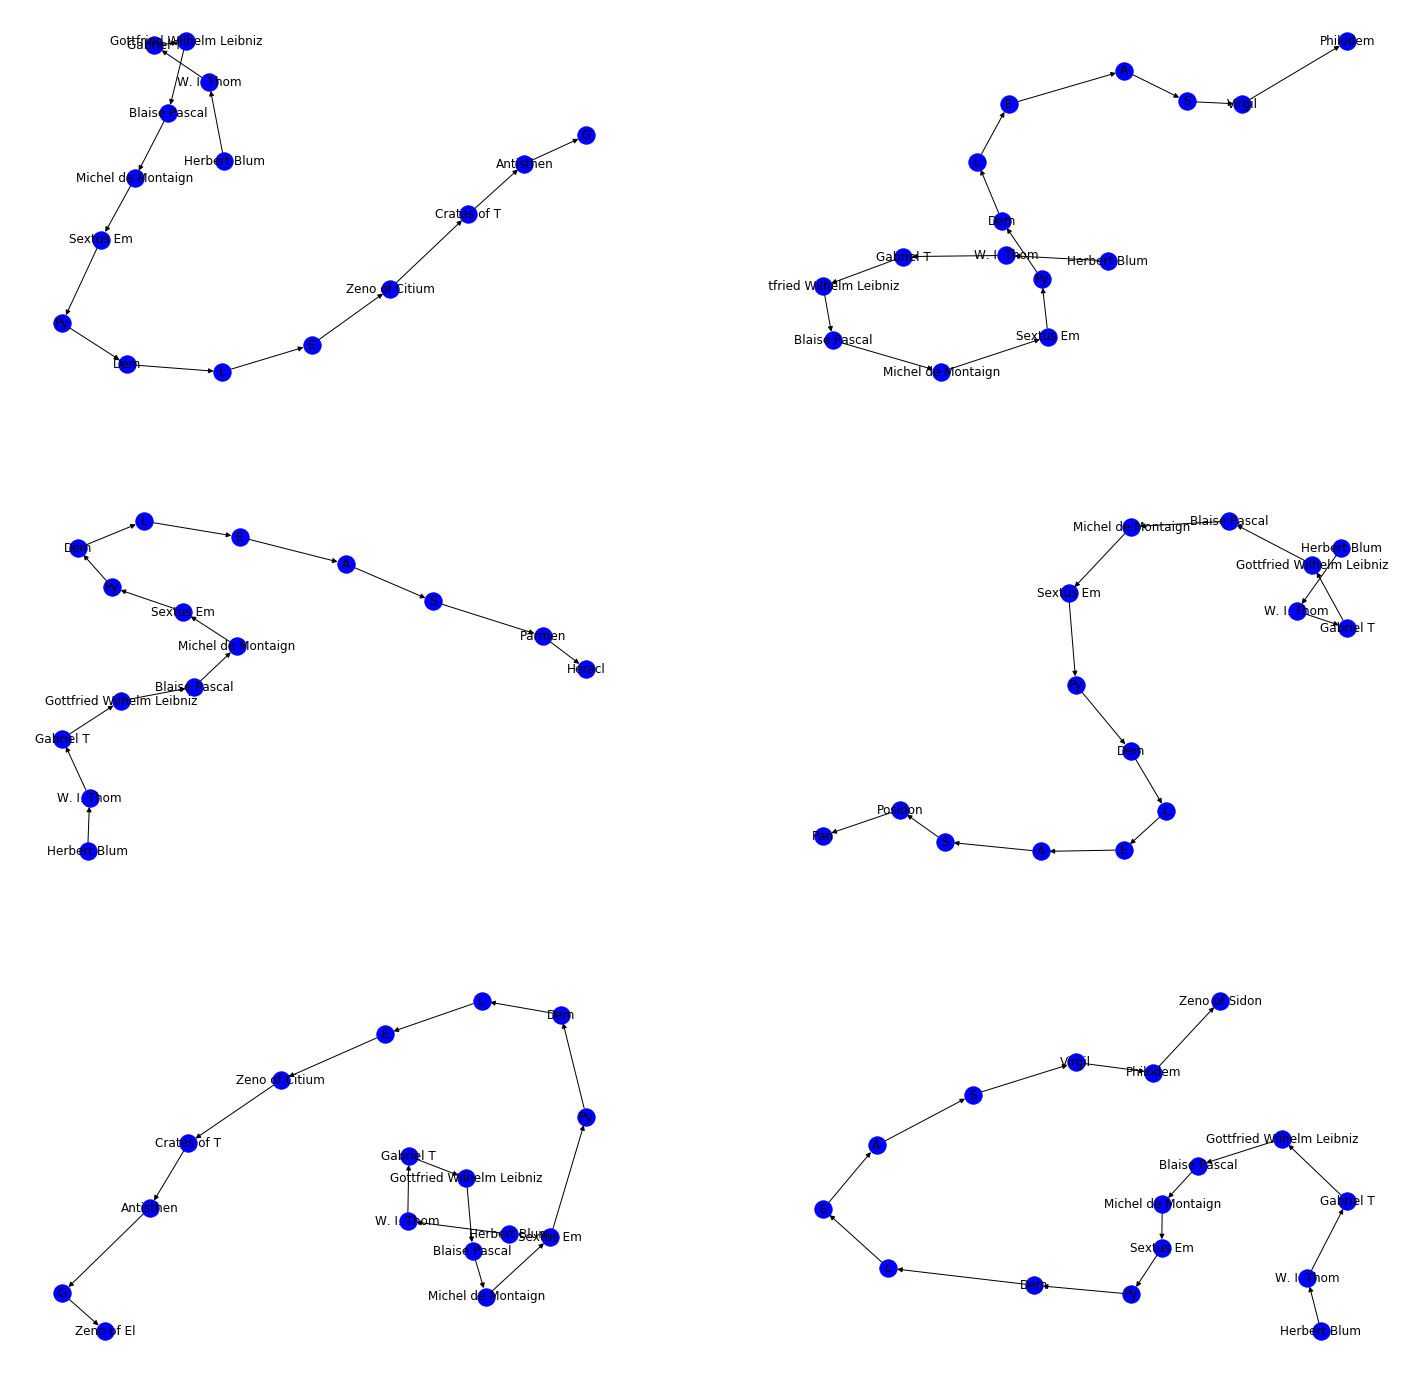

In [34]:
fig = plt.figure(figsize= (25, 25) )
index = 1

for i in longest_paths:
    print("Path " + str(index) + ": " + str(i) + "\n")
    graph = nx.DiGraph()
    nx.function.add_path(graph, i)
    ax = fig.add_subplot(3,2, index)
    pos = nx.drawing.fruchterman_reingold_layout(graph)
    nx.draw(graph, pos, node_color='blue', with_labels=True) 
    index += 1
    if index > 6:
        break

5) What are the countries that generated the greatest influential? 

In [35]:
#Scraping data from Wikipedia
nationality = []
main_interests = []

for i in range(0,10):
        name = df_influencers.Influencer[i].replace(' ','_')
        url= 'http://pt.wikipedia.org/wiki/' + name
        source = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(source, "lxml")
        information_with_tags = soup.findAll('td')
        information = [t.getText() for t in information_with_tags]
        if 'Nacionalidade' in information:
            nationality_index = information.index('Nacionalidade')
            nationality = nationality + [information[nationality_index +1]]
        else: 
            nationality = nationality + ['Nationality not found']
        if 'Principais Interesses' in information:
            interest_index = information.index('Principais Interesses')
            main_interests = main_interests + ['\\'] +[information[interest_index +1]]
        else: 
            main_interests = main_interests + ['\\'] + ['Interests not found']

HTTPError: HTTP Error 404: Not Found

In [ ]:
for i in range(0,10):
    print('{}\t\t has nationality {}'.format(df_influencers.Influencer[i], nationality[i]))

6) What are the areas of greatest influence? 

In [ ]:
for i in range(0,10):
    print('{}\t\t area is {}'.format(df_influencers.Influencer[i], main_interests[i]))

7) Create a graphical representation of the graph 

In [ ]:
plt.figure(figsize=(12,12))
nx.draw(G, with_labels=False, font_size=False, node_size=False, node_color='r', arrows=False, alpha=0.1)

In [ ]:
print("Nodes on graph: " + str(G.number_of_nodes()))
print("Connected components: " + str(nx.number_weakly_connected_components(G)))

In [ ]:
fig = plt.figure(figsize=(25,25))

G2=nx.weakly_connected_component_subgraphs(G)
for g in G2:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    plt.title('Representacao do Grafo')
    nx.draw_spring(g, node_size=40, node_color=c, edge_color='#E6E6E6', vmin=0.0, vmax=1.0, with_labels=False, edge_cmap=plt.cm.gray )

Exporting to Gephi  
https://gephi.org/users/supported-graph-formats/  